# Visualize grit calculated per compartment

Previously, we calculated grit using the following subsets:

* Per compartment (Cells, Cytoplasm, Nuclei)
* Per compartment feature group (Cells x AreaShape, Cells x Correlation, Nuclei x Texture, etc.)
* Per channel (DNA, RNA, AGP, ER, Mito)
    * Use all features that include any information from one of these channels
* No feature subsetting

Here, we visualize these results.

In [1]:
import pathlib
import pandas as pd
import plotnine as gg

In [2]:
output_dir = pathlib.Path("figures/compartment_drop")

cell_health_dir = pathlib.Path("../../1.calculate-metrics/cell-health/results")
grit_file = pathlib.Path(f"{cell_health_dir}/cell_health_grit.tsv")
compartment_grit_file = pathlib.Path(f"{cell_health_dir}/cell_health_grit_compartments.tsv.gz")

In [3]:
cell_line_colors = {
  "A549": "#861613",
  "ES2": "#1CADA8",
  "HCC44": "#2A364D"
}

compartment_drop_theme = gg.theme(
    strip_background=gg.element_rect(color="black", fill="#fdfff4"),
    strip_text_x=gg.element_text(size=6),
    axis_text=gg.element_text(size=7),
    axis_title=gg.element_text(size=8),
    legend_title=gg.element_text(size=6),
    legend_text=gg.element_text(size=5),
    panel_grid=gg.element_line(size=0.35)
)

grit_results = (
    pd.read_csv(grit_file, sep="\t")
    .assign(compartment="all", feature_group="all", channel="all")
    .query("barcode_control == 'cutting_control'")
    .query("grit_replicate_summary_method == 'mean'")
    .query("cor_method == 'pearson'")
)

grit_results = grit_results.assign(num_features=grit_results.shape[0])
compartment_grit_results = pd.read_csv(compartment_grit_file, sep="\t")

## 1) Per compartment grit

In [4]:
per_compartment_df = (
    compartment_grit_results
    .query("compartment != 'all'")
    .query("feature_group == 'all'")
    .query("channel == 'all'")
)

print(
    pd.crosstab(
        per_compartment_df.num_features,
        per_compartment_df.compartment
    )
)

print(per_compartment_df.shape)
per_compartment_df.head()

compartment   Cells  Cytoplasm  Nuclei
num_features                          
100             714          0       0
142               0        714       0
153               0          0     714
(2142, 11)


,perturbation,group,grit,cell_line,barcode_control,cor_method,compartment,channel,feature_group,num_features,dropped_or_exclusive
0,AKT1-1,AKT1,0.821396,HCC44,cutting_control,pearson,Cells,all,all,100,dropped
1,AKT1-2,AKT1,0.799205,HCC44,cutting_control,pearson,Cells,all,all,100,dropped
2,ARID1B-1,ARID1B,0.425039,HCC44,cutting_control,pearson,Cells,all,all,100,dropped
3,ARID1B-2,ARID1B,0.310649,HCC44,cutting_control,pearson,Cells,all,all,100,dropped
4,ATF4-1,ATF4,0.231863,HCC44,cutting_control,pearson,Cells,all,all,100,dropped


In [5]:
per_compartment_df = (
    per_compartment_df
    .pivot(
        index=["perturbation", "group", "cell_line", "compartment"],
        values="grit",
        columns="dropped_or_exclusive"
    )
    .reset_index()
)

per_compartment_df = (
    per_compartment_df
    .assign(channel_signal = per_compartment_df.exclusive - per_compartment_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_compartment_df.shape)
per_compartment_df.head(20)

(1071, 7)


dropped_or_exclusive,perturbation,group,cell_line,compartment,dropped,exclusive,channel_signal
0,CDK2-2,CDK2,HCC44,Nuclei,1.526353,3.287294,1.760941
1,CDK2-1,CDK2,HCC44,Nuclei,1.673176,3.093356,1.420181
2,ITGAV-2,ITGAV,ES2,Cytoplasm,2.047934,3.033220,0.985285
3,MAPK1-2,MAPK1,HCC44,Nuclei,0.520351,1.502240,0.981890
4,BRCA1-2,BRCA1,HCC44,Nuclei,0.206473,1.027178,0.820705
5,ITGAV-1,ITGAV,ES2,Cytoplasm,1.953266,2.769977,0.816711
6,EGFR-2,EGFR,HCC44,Nuclei,-0.215573,0.599314,0.814886
7,EGLN1-9,EGLN1,ES2,Cytoplasm,1.588177,2.382515,0.794338
8,CDK2-2,CDK2,ES2,Nuclei,1.719942,2.502869,0.782927
9,PIK3CA-1,PIK3CA,HCC44,Nuclei,0.005336,0.779580,0.774244


/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 3 in image.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/compartment_drop/cell_health_grit_compartment_drop.png
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 54 rows containing missing values.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 54 rows containing missing values.


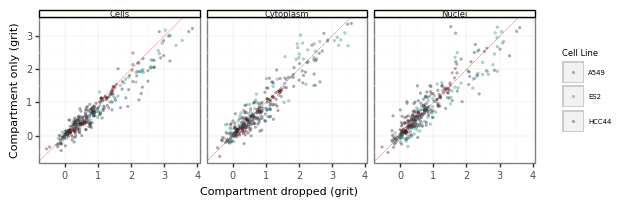

<ggplot: (675530350)>

In [6]:
compartment_drop_gg = (
    gg.ggplot(per_compartment_df, gg.aes(x="dropped", y="exclusive"))
    + gg.geom_point(gg.aes(fill="cell_line"), alpha=0.4, size=1, stroke=0.1)
    + gg.facet_grid("~compartment")
    + gg.xlab("Compartment dropped (grit)")
    + gg.ylab("Compartment only (grit)")
    + gg.coord_fixed()
    + gg.geom_abline(intercept=0, slope=1, size=0.15, color="red", linetype="dashed")
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + compartment_drop_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_grit_compartment_drop.png")
compartment_drop_gg.save(output_file, dpi=500, height=3, width=6)

compartment_drop_gg

## 2) Per compartment feature group

In [7]:
per_featuregroup_df = (
    compartment_grit_results
    .query("compartment != 'all'")
    .query("feature_group != 'all'")
    .query("channel == 'all'")
    .query("feature_group != 'Location'")
    .pivot(
        index=["perturbation", "group", "cell_line", "channel", "feature_group", "compartment"],
        values="grit",
        columns="dropped_or_exclusive")
    .reset_index()
)

per_featuregroup_df = (
    per_featuregroup_df
    .assign(channel_signal = per_featuregroup_df.exclusive - per_featuregroup_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_featuregroup_df.shape)
per_featuregroup_df.head(20)

(6426, 9)


dropped_or_exclusive,perturbation,group,cell_line,channel,feature_group,compartment,dropped,exclusive,channel_signal
0,BRCA1-1,BRCA1,HCC44,all,AreaShape,Nuclei,0.326433,1.759206,1.432773
1,BRCA1-2,BRCA1,HCC44,all,AreaShape,Nuclei,0.358422,1.724532,1.366111
2,PIK3CA-1,PIK3CA,HCC44,all,Texture,Nuclei,0.024078,1.217413,1.193335
3,CDK2-2,CDK2,HCC44,all,Texture,Nuclei,1.818860,2.717210,0.898350
4,EGLN1-9,EGLN1,ES2,all,Texture,Cytoplasm,1.746196,2.572491,0.826295
5,EGFR-2,EGFR,A549,all,RadialDistribution,Cytoplasm,0.097234,0.906689,0.809455
6,JAK3-2,JAK3,HCC44,all,AreaShape,Nuclei,0.298989,1.099060,0.800071
7,MAPK1-2,MAPK1,HCC44,all,Texture,Nuclei,0.721248,1.513171,0.791923
8,RHOA-1,RHOA,ES2,all,AreaShape,Nuclei,2.028360,2.806102,0.777741
9,BCL2-1,BCL2,ES2,all,RadialDistribution,Cytoplasm,-0.260167,0.517121,0.777288


/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/compartment_drop/cell_health_grit_featuregroup_drop.png
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 324 rows containing missing values.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 324 rows containing missing values.


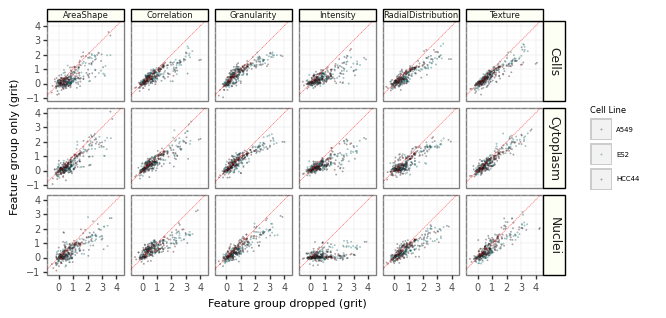

<ggplot: (276321419)>

In [8]:
feature_group_drop_gg = (
    gg.ggplot(per_featuregroup_df, gg.aes(x="dropped", y="exclusive"))
    + gg.geom_point(gg.aes(fill="cell_line"), alpha=0.4, size=0.5, stroke=0.1)
    + gg.facet_grid("compartment~feature_group")
    + gg.xlab("Feature group dropped (grit)")
    + gg.ylab("Feature group only (grit)")
    + gg.coord_fixed()
    + gg.geom_abline(intercept=0, slope=1, size=0.15, color="red", linetype="dashed")
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + compartment_drop_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_grit_featuregroup_drop.png")
feature_group_drop_gg.save(output_file, dpi=500, height=6, width=8)

feature_group_drop_gg

## 3) Per channel grit

In [9]:
per_channel_df = (
    compartment_grit_results
    .query("compartment == 'all'")
    .query("feature_group == 'all'")
    .query("channel != 'all'")
    .pivot(index=["perturbation", "group", "cell_line", "channel"], values="grit", columns="dropped_or_exclusive")
    .reset_index()
)

per_channel_df = (
    per_channel_df
    .assign(channel_signal = per_channel_df.exclusive - per_channel_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_channel_df.shape)
per_channel_df.head(10)

(1785, 7)


dropped_or_exclusive,perturbation,group,cell_line,channel,dropped,exclusive,channel_signal
0,EGLN1-8,EGLN1,ES2,Mito,1.887721,2.945044,1.057323
1,SMARCB1-1,SMARCB1,HCC44,AGP,0.306464,1.219344,0.912881
2,SMARCB1-2,SMARCB1,HCC44,AGP,0.481427,1.373046,0.891619
3,CCND1-2,CCND1,HCC44,AGP,0.025798,0.880777,0.854979
4,COX5B-1,COX5B,A549,Mito,0.432138,1.265963,0.833825
5,CDK2-1,CDK2,HCC44,DNA,1.936312,2.715691,0.779380
6,COX5B-2,COX5B,A549,Mito,0.191161,0.948890,0.757728
7,LacZ-3,LacZ,HCC44,Mito,0.140440,0.895595,0.755155
8,CTNNB1-1,CTNNB1,A549,Mito,-0.639206,0.083338,0.722544
9,LacZ-2,LacZ,HCC44,Mito,0.054341,0.774865,0.720523


/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 3 in image.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/compartment_drop/cell_health_grit_channel_drop.png
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 90 rows containing missing values.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 90 rows containing missing values.


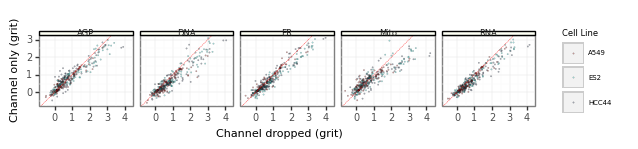

<ggplot: (686255696)>

In [10]:
channel_drop_gg = (
    gg.ggplot(per_channel_df, gg.aes(x="dropped", y="exclusive"))
    + gg.geom_point(gg.aes(fill="cell_line"), alpha=0.4, size=0.5, stroke=0.1)
    + gg.facet_grid("~channel")
    + gg.xlab("Channel dropped (grit)")
    + gg.ylab("Channel only (grit)")
    + gg.geom_abline(intercept=0, slope=1, size=0.15, color="red", linetype="dashed")
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.coord_fixed()
    + gg.theme_bw()
    + compartment_drop_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_grit_channel_drop.png")
channel_drop_gg.save(output_file, dpi=500, height=3, width=6)

channel_drop_gg